In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tnrange, tqdm_notebook
import gc

In [2]:
sns.set_context('talk')

# Read the data

In [41]:
dfXtrain = pd.read_csv('preprocessed_csv/train.csv', index_col='id')
dfXtest = pd.read_csv('preprocessed_csv/test.csv', index_col='id')
dfYtrain = pd.read_csv('preprocessed_csv/y_train.csv', header=None, names=['id', 'proba'], index_col='id')

In [62]:
anomaly = {'car_age': 1, 'income': 0, 'home_val': 0, 'yoj': 0}

def return_index(df, col, mask):
    if mask == 0:
        return (df[col] == anomaly[col])
    else:
        return (df[col] != anomaly[col])     

In [63]:
def compute_indices(car_age, income, home_val, yoj, df):
    return (return_index(df, 'income', income) & return_index(df, 'home_val', home_val)) & \
           (return_index(df, 'yoj', yoj) & return_index(df, 'car_age', car_age)) 

In [64]:
COMP_NUM = 16

x_train = [0 for i in range(COMP_NUM)]
x_test = [0 for i in range(COMP_NUM)]
y_train = [0 for i in range(COMP_NUM)]
dfYtest = [0 for i in range(COMP_NUM)]

for car_age in range(2):
    for income in range(2):
        for home_val in range(2):
            for yoj in range(2):
                mask = car_age * 8 + income * 4 + home_val * 2 + yoj
                train_indices = compute_indices(car_age, income, home_val, yoj, dfXtrain)
                test_indices = compute_indices(car_age, income, home_val, yoj, dfXtest)
                x_train[mask] = np.array(dfXtrain[train_indices])
                y_train[mask] = np.array(dfYtrain[train_indices]['proba'])
                x_test[mask] = np.array(dfXtest[test_indices])
                dfYtest[mask] = pd.DataFrame({'INDEX': dfXtest.index})

In [73]:
for mask in range(COMP_NUM):
    print(x_train[mask].shape[0], '{:.2}'.format(y_train[mask].sum() / x_train[mask].shape[0]))

162 0.44
38 0.42
100 0.38
73 0.27
33 0.33
633 0.38
72 0.28
1333 0.26
244 0.45
78 0.26
180 0.29
185 0.17
86 0.34
1484 0.31
202 0.18
3258 0.2


# Save routines

In [6]:
def save_to_file(y, file_name):
    dfYtest['P_TARGET_FLAG'] = y
    dfYtest.to_csv('results/{}'.format(file_name), index=False)

# Train RF

In [26]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import train_test_split

In [8]:
def get_score_list(X, y, clf, scorer):
    predictions = list()
    score = list()
    for i, tree in enumerate(clf.estimators_):
        proba = tree.predict_proba(X)[:, 1]
        predictions.append(proba)
        rf_prediction = np.mean(predictions, axis=0)
        score.append(scorer(y, rf_prediction))
    return score

In [9]:
def plot_score_graph(clf, X_train, X_test, y_train, y_test, scorer, prefix, print_train=True):
    clf.fit(X_train, y_train)
    if print_train:
        train_score = get_score_list(X_train, y_train, clf, scorer)
    test_score = get_score_list(X_test, y_test, clf, scorer)
    if print_train:
        plt.plot(train_score, label=prefix + ' train set error')
    plt.plot(test_score, label=prefix + ' test set error')
    plt.xlabel('n_estimators')
    plt.ylabel('score')
    plt.legend()
    return test_score, clf

In [10]:
def combine_rfs(rf_a, rf_b):
    rf_a.estimators_ += rf_b.estimators_
    rf_a.n_estimators = len(rf_a.estimators_)
    return rf_a

In [11]:
x_subtrain, x_subtest, y_subtrain, y_subtest = train_test_split(x_train, y_train, 
                                                                test_size=0.15, random_state=42,
                                                                stratify=y_train)

In [30]:
%%time

kwargs = {'n_estimators': 1000, 'criterion': 'entropy', 'n_jobs': -1, 'random_state': 56}

rfc = RFC(**kwargs)
rfc.fit(x_subtrain, y_subtrain)
rfc_test_score = get_score_list(x_subtest, y_subtest, rfc, roc_auc_score)

CPU times: user 28.7 s, sys: 51.6 ms, total: 28.7 s
Wall time: 11.5 s


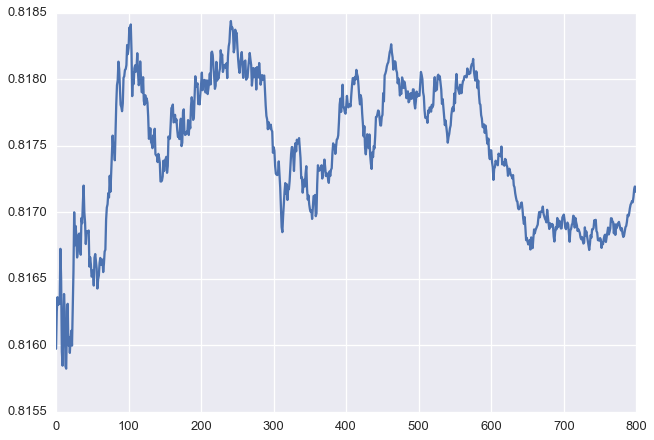

In [32]:
plt.plot(rfc_test_score[200:])